In [1]:
import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from skimage.io import ImageCollection, imsave
from skimage.color import rgb2hsv, rgb2gray, gray2rgb
from skimage.transform import resize, warp, SimilarityTransform, AffineTransform, ProjectiveTransform
from skimage.feature import (ORB, match_descriptors, corner_harris, corner_peaks, BRIEF,)
from skimage.measure import ransac
from skimage.util import img_as_float
from numpy.random import randint
from skimage.data import imread

from skimage.measure import label
from skimage.graph import route_through_array
from sklearn.feature_extraction import image
from subprocess import Popen, PIPE
from multiprocessing import Pool, freeze_support, cpu_count
import itertools
from scipy.ndimage import rotate
import math
%matplotlib inline
path_to_enblend = '/Users/jhansen/Applications/enblend-enfuse-4.0-mac/enblend'
tmp_out = '/tmp/out.png'
tmp_base = '/tmp/base.png'
tmp_img = '/tmp/img.png'
data_dir = '../data/jpg/'
import peakutils
import detect_peaks

from shutil import copyfile
import subprocess
from subprocess import Popen, PIPE
from multiprocessing import Pool, freeze_support, cpu_count
import matplotlib.pyplot as plt
import itertools
import os
from glob import glob
import numpy as np
import argparse
import sys
from mahotas.zernike import zernike_moments
from itertools import islice
import cv2
from copy import copy, deepcopy
from scipy.ndimage import rotate

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
import config
import math

%autoreload 2


from skimage.io import imread, imsave
from skimage.color import gray2rgb, rgb2gray
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.transform import warp, SimilarityTransform, AffineTransform, ProjectiveTransform
from skimage import img_as_float, img_as_ubyte
%matplotlib inline
rsn = 4
import mosaic as m


ERROR: Line magic function `%autoreload` not found.


In [2]:
label_name =["bad","iceberg","mix","slush","ship","cake","water"]
ice_water_label_name = ["ice", "water", "mix"]
def load_img_labels():
    bimgs = sorted(glob('/Users/jhansen/johannah/js-segment-annotator/data/images/*.jpg'))
    annot = sorted(glob('/Users/jhansen/johannah/js-segment-annotator/data/annotations/*.png'))
    imgs = {}
    for xx, a in enumerate(annot):
        nval = int(os.path.split(a)[1].replace(".png", '')) 
        imgpath = bimgs[nval]
        imgname = os.path.split(imgpath)[1]
        #print(nval, imgname)
        imgs[nval] = {'img':imread(bimgs[nval]), 'label':imread(a)[:,:,0], 'name':imgname }

    return imgs
imgs = load_img_labels()

DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM IDAT 41 8192
DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM IDAT 41 8192
DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM IDAT 41 8192
DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM IDAT 41 8192
DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM IDAT 41 8192
DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM IDAT 41 8051
DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM IDAT 41 7720
DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM IDAT 41 6906
DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM IDAT 41 7398
DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM IDAT 41 5690
DEBUG:PIL.PngImagePlugin:STREAM IHDR 16 13
DEBUG:PIL.PngImagePlugin:STREAM IDAT 41 8192
DEBUG:PIL.PngImagePlugin:STREAM 

In [3]:

for v in sorted(imgs.keys()):
    label = imgs[v]['label']
    ice_water = np.zeros_like(label)

    label[label == label_name.index("bad")] = label_name.index("slush")

    ilabel, clabel = np.unique(label, return_counts=True)
    occ = zip(ilabel,clabel) 
    #print(occ)
    for lval, num_label in occ:
        if num_label < 50:
            label[label==lval] = label_name.index('slush')
    ice_water[label==label_name.index("water")] = 1
    ice_water[label==label_name.index("mix")] = 2
    imgs[v]['ice_water'] = ice_water

    ilabel, clabel = np.unique(label, return_counts=True)
    occ = zip(ilabel,clabel)        
    #print(occ)
    if False:
        for lval, num_label in occ:
            #plt.figure()
            f, (ax1, ax2) = plt.subplots(1, 2)
            ax1.set_title("Label: %s Count Num: %s" %(label_name[lval], num_label))
            ax2.set_title("Name: %s -Image Num: %s" %(imgs[v]['name'], v) )
            thisval = (label == lval)
            ax1.imshow(thisval)
            ax2.imshow(imgs[v]['img'])
            ax1.axes.yaxis.set_ticklabels([])
            ax2.axes.yaxis.set_ticklabels([])
            ax1.axes.xaxis.set_ticklabels([])
            ax2.axes.xaxis.set_ticklabels([])


In [4]:
imgs.keys()

[68,
 96,
 2,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 140,
 141,
 136,
 20,
 97,
 25,
 95,
 70,
 94,
 69]

In [5]:
len(imgs.keys())

21

(400, 600)

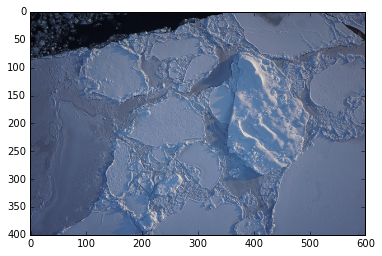

In [13]:
k=100
img = imgs[k]['img']
iw = imgs[k]['ice_water']
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img)
iw.shape

In [42]:
def compute_jaccard_index(img1, img2):
    assert set(np.unique(img1)) == set([0,1])
    assert set(np.unique(img1)) == set([0,1])
    intersect = img1 & img2
    union = img1 | img2
    return  np.sum(intersect) / float(np.sum(union))
Alice = np.array([[0, 1, 0],
                  [0, 1, 0],
                  [0, 1, 0]])

RobotBob = np.array([[0, 0, 0],
                     [0, 1, 1],
                     [0, 0, 1]])
compute_jaccard_index(Alice, RobotBob)

0.20000000000000001

Some water


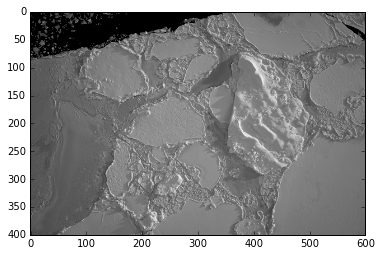

In [55]:
def find_hist_peaks(tgray, do_plot=False):
    hist = np.histogram(tgray, bins=np.arange(0, 256))
    peaks = peakutils.indexes(hist[0], thres=0.5, min_dist=30)
    valleys = detect_peaks.detect_peaks(hist[0],valley=True, edge='rising', kpsh=False,  threshold=30,mpd=30)
    if do_plot:
        fig, axes = plt.subplots(1, 2, figsize=(8, 3))
        axes[0].imshow(tgray, cmap=plt.cm.gray, interpolation='nearest')
        axes[0].axis('off')
        axes[1].plot(hist[1][:-1], hist[0], lw=2)
        axes[1].scatter(peaks, hist[0][peaks], c='r', s=100, marker='x')
        axes[1].scatter(valleys, hist[0][valleys], c='g', s=100, marker='x')
        axes[1].set_title('histogram of gray values')
    
    return hist, peaks, valleys

def find_water(tgray, do_plot=False, water_threshold = 30):
    hist, peaks, valleys = find_hist_peaks(tgray, do_plot)
    # need to figure out if there is water
    is_water = peaks<water_threshold
    water = peaks[is_water]
    not_water = peaks[~is_water]
    if len(water):
        if len(not_water):
            print("Some water")
            has_water = True
            new_water_thresh = valleys[valleys<not_water[0]][-1]
        else:
            print("All water")
            new_water_thresh = 255
            has_water = True
            print(new_water_thresh)
    else:
        new_water_thresh = -1
        has_water = False
        print("No water")
    tgray[tgray<new_water_thresh] = 0    
    
    return tgray, new_water_thresh


    
water0, water_thresh=find_water(deepcopy(gray), False)
plt.imshow(water0, cmap=plt.cm.gray)




In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.figure()
plt.imshow(thresh)
# noise removal
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
plt.figure()
plt.imshow(opening)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
plt.figure()
plt.imshow(sure_bg)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_LABEL_PIXEL,3)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)


In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage import data
from scipy import ndimage
timg = deepcopy(img)
tgray = deepcopy(gray)
# noise removal

#Thresh coins are black, background is white
ret, thresh = cv2.threshold(tgray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
# opening closes small holes
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area - grow bright regions
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dt= cv2.distanceTransform(src=opening,distanceType=cv2.cv.CV_DIST_L2, maskSize=5)
ret, sure_fg = cv2.threshold(dt,0.1*dt.max(),255,0)
dt[sure_bg==0] == 0
dt[sure_fg == 255] = 255
#local_maxi = peak_local_max(, indices=False, footprint=np.ones((3, 3)),
#                            labels=image)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
#markers = ndimage.label()
plt.gray()
plt.imshow(dt)

In [ ]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max

    
def get_ice(timg, tgray):
    timg = deepcopy(timg)
    tgray = deepcopy(tgray)
    #Thresh coins are black, background is white
    ret, thresh = cv2.threshold(tgray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((1,1),np.uint8)
    # opening closes small holes and remove noise
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dt = cv2.distanceTransform(src=opening,distanceType=cv2.cv.CV_DIST_L2, maskSize=5)

    ret, sure_fg = cv2.threshold(dt,0.1*dt.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    markers = ndimage.label(sure_fg)[0]
    # add one so foreground and background are numbered
    markers +=1
    
    # mark unknown region with 0
    markers[unknown == 255] = 0
    
    plt.figure()
    print('after', sorted(set(markers.ravel())))
    plt.title("Markers")
    plt.imshow(markers, cmap=plt.cm.spectral)
    # cv watershed overwrites markers in place
    cv2.watershed(timg, markers)

    #print(labels)
    timg[markers==-1] =[255,0,0]
 
  

    plt.figure()
    plt.title("LABELS")
    plt.imshow(timg, cmap=plt.cm.spectral)
    #a = np.zeros_like(markers)
    #a[markers == 0] = 1
    #lt.figure()
    #plt.imshow(a)
    if True:
        plt.figure()
        plt.title("Sure background is black")
        plt.imshow(sure_bg)

        plt.figure()
        plt.title("Sure foreground is white")
        plt.imshow(sure_fg)
#get_ice(img, gray)

def seperate_ice_water(timg, tgray):
    timg = deepcopy(timg)
    tgray = deepcopy(tgray)
    hist, indexes, has_water = hist_peaks(tgray, True)
    if has_water:
        print("WATER PRESENT")
        print(indexes)
        ret, water0 = cv2.threshold(tgray, 30, 255, cv2.THRESH_BINARY)
        plt.figure()
        plt.title("WATER")
        plt.imshow(thresh)
seperate_ice_water(img, gray)

In [ ]:
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage import morphology
edges = canny(gray)

plt.figure()
plt.imshow(gray)
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(edges, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('Canny detector')
ax.axis('off')
ax.set_adjustable('box-forced')




In [ ]:
from skimage.filters import sobel

elevation_map = sobel(gray)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('elevation map')
ax.axis('off')
ax.set_adjustable('box-forced')


markers = np.zeros_like(gray)
markers[gray < 30] = 1
markers[gray > 50] = 2
markers[gray > 100] = 3
markers[gray > 120] = 4
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=plt.cm.spectral, interpolation='nearest')
ax.set_title('markers')
ax.axis('off')
ax.set_adjustable('box-forced')

segmentation = morphology.watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('segmentation')
ax.axis('off')
ax.set_adjustable('box-forced')

from skimage.color import label2rgb

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=gray)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(gray, cmap=plt.cm.gray, interpolation='nearest')
axes[0].contour(segmentation, [0.5], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay, interpolation='nearest')

for a in axes:
    a.axis('off')
    a.set_adjustable('box-forced')

plt.tight_layout()

In [ ]:
from skimage import data, io, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt


img = img#data.coffee()

labels1 = segmentation.slic(img, compactness=30, n_segments=400)
out1 = color.label2rgb(labels1, img, kind='avg')

g = graph.rag_mean_color(img, labels1)
labels2 = graph.cut_threshold(labels1, g, 29)
out2 = color.label2rgb(labels2, img, kind='avg')

plt.figure()
io.imshow(out1)
plt.figure()
io.imshow(out2)
io.show()

In [ ]:
from skimage import data, io, segmentation, color
from skimage.future import graph
import numpy as np


def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    weight : float
        The absolute difference of the mean color between node `dst` and `n`.
    """

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return diff


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])


img = img #data.coffee()
labels = segmentation.slic(img, compactness=5, n_segments=400)
g = graph.rag_mean_color(img, labels)

labels2 = graph.merge_hierarchical(labels, g, thresh=40, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

g2 = graph.rag_mean_color(img, labels2)

out = color.label2rgb(labels2, img, kind='avg')
out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))
io.imshow(out)
io.show()
print(set(labels2.ravel()))
plt.figure()
plt.imshow(img)

In [ ]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

#img = img_as_float(img[::2, ::2])
limg = img_as_float(img)
segments_fz = felzenszwalb(limg, scale=200, sigma=0.5, min_size=20)
segments_slic = slic(limg, n_segments=250, compactness=10, sigma=1)
segments_quick = quickshift(limg, kernel_size=4, max_dist=6, ratio=0.5)

print("Felzenszwalb's number of segments: %d" % len(np.unique(segments_fz)))
print("Slic number of segments: %d" % len(np.unique(segments_slic)))
print("Quickshift number of segments: %d" % len(np.unique(segments_quick)))

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True,
                       subplot_kw={'adjustable': 'box-forced'}, figsize=(10,10))
fig.set_size_inches(8, 3, forward=True)
fig.tight_layout()

ax[0].imshow(mark_boundaries(limg, segments_fz))
ax[0].set_title("Felzenszwalbs's method")
ax[1].imshow(mark_boundaries(limg, segments_slic))
ax[1].set_title("SLIC")
ax[2].imshow(mark_boundaries(limg, segments_quick))
ax[2].set_title("Quickshift")
for a in ax:
    a.set_xticks(())
    a.set_yticks(())
plt.show()

In [ ]:
gray.shape

In [ ]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import watershed, disk
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte


image = img_as_ubyte(gray)

# denoise image
denoised = rank.median(image, disk(2))

# find continuous region (low gradient -
# where less than 10 for this image) --> markers
# disk(5) is used here to get a more smooth image
markers = rank.gradient(denoised, disk(5)) < 10
markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(denoised, disk(2))

# process the watershed
labels = watershed(gradient, markers)

# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
ax = axes.ravel()

ax[0].imshow(denoised, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.spectral, interpolation='nearest')
ax[1].set_title("Local Gradient")

ax[2].imshow(markers, cmap=plt.cm.spectral, interpolation='nearest')
ax[2].set_title("Markers")

ax[3].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[3].imshow(labels, cmap=plt.cm.spectral, interpolation='nearest', alpha=.7)
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()
#plt.show()

In [ ]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt



labels1 = segmentation.slic(img, compactness=30, n_segments=400)
out1 = color.label2rgb(labels1, img, kind='avg')

g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg')



labels1 = segmentation.slic(img, compactness=30, n_segments=400)
out1 = color.label2rgb(labels1, img, kind='avg')

g3 = graph.rag_mean_color(img, labels1)




labels3 = graph.cut_threshold(labels1, g3, 29)
out3 = color.label2rgb(labels3, img, kind='avg')



fig, ax = plt.subplots(nrows=4, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)
ax[2].imshow(out3)
ax[3].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()


In [ ]:
import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data


PATCH_SIZE = 15

# open the camera image
image = gray

# select some patches from floe areas of the image
# iceberg
cake_locations = [(120, 20), (40, 140), (50, 300), (150, 50)]#, (390, 433), (166, 18), (262, 236)]
cake_patches = []
for loc in cake_locations:
    cake_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from water areas of the image
water_locations = [(354, 248), (321, 233), (350, 360), (325, 330)]
water_patches = []
for loc in water_locations:
    water_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
xs = []
ys = []
for patch in (cake_patches + water_patches):
    glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest',
          vmin=0, vmax=255)
for (y, x) in cake_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in water_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
#ax.set_xticks([])
#ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(cake_patches)], ys[:len(cake_patches)], 'go',
        label='cake')
ax.plot(xs[len(cake_patches):], ys[len(cake_patches):], 'bo',
        label='water')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLVM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(cake_patches):
    ax = fig.add_subplot(3, len(cake_patches), len(cake_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('cake %d' % (i ))

for i, patch in enumerate(water_patches):
    ax = fig.add_subplot(3, len(water_patches), len(sky_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray, interpolation='nearest',
              vmin=0, vmax=255)
    ax.set_xlabel('water %d' % (i ))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14)
plt.show()

In [ ]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon, \
    subdivide_polygon


hand = np.array([[1.64516129, 1.16145833],
                 [1.64516129, 1.59375],
                 [1.35080645, 1.921875],
                 [1.375, 2.18229167],
                 [1.68548387, 1.9375],
                 [1.60887097, 2.55208333],
                 [1.68548387, 2.69791667],
                 [1.76209677, 2.56770833],
                 [1.83064516, 1.97395833],
                 [1.89516129, 2.75],
                 [1.9516129, 2.84895833],
                 [2.01209677, 2.76041667],
                 [1.99193548, 1.99479167],
                 [2.11290323, 2.63020833],
                 [2.2016129, 2.734375],
                 [2.25403226, 2.60416667],
                 [2.14919355, 1.953125],
                 [2.30645161, 2.36979167],
                 [2.39112903, 2.36979167],
                 [2.41532258, 2.1875],
                 [2.1733871, 1.703125],
                 [2.07782258, 1.16666667]])

# subdivide polygon using 2nd degree B-Splines
new_hand = hand.copy()
for _ in range(5):
    new_hand = subdivide_polygon(new_hand, degree=2, preserve_ends=True)

# approximate subdivided polygon with Douglas-Peucker algorithm
appr_hand = approximate_polygon(new_hand, tolerance=0.02)

print("Number of coordinates:", len(hand), len(new_hand), len(appr_hand))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 4))

ax1.plot(hand[:, 0], hand[:, 1], label="hand")
ax1.plot(new_hand[:, 0], new_hand[:, 1], label="new hand")
ax1.plot(appr_hand[:, 0], appr_hand[:, 1], label="approximate hand")


# create two ellipses in image
rimg = np.zeros((800, 800), 'int32')
rr, cc = ellipse(250, 250, 180, 230, rimg.shape)
img[rr, cc] = 1
#rr, cc = ellipse(600, 600, 150, 90, img.shape)
#img[rr, cc] = 1

plt.gray()
ax2.imshow(img)

# approximate / simplify coordinates of the two ellipses
# find countour at pixel value 0
for contour in find_contours(rimg, 0):
    coords = approximate_polygon(contour, tolerance=2.5)
    ax2.plot(coords[:, 1], coords[:, 0], '-r', linewidth=2, label="low tolerance")
    coords2 = approximate_polygon(contour, tolerance=29.5)
    ax2.plot(coords2[:, 1], coords2[:, 0], '-g', linewidth=2, label="high tolerance")
    print("Number of coordinates:", len(contour), len(coords), len(coords2))
    

ax2.axis((0, 800, 0, 800))
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure


# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))

# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import camera
from skimage.filters import roberts, sobel, scharr, prewitt


image = gray
edge_roberts = roberts(image)
edge_sobel = sobel(image)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(8, 4))

ax[0].imshow(edge_roberts, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
ax[1].set_title('Sobel Edge Detection')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#x, y = np.ogrid[:100, :100]
# Rotation-invariant image with different spatial frequencies
#img = np.exp(1j * np.hypot(x, y)**1.3 / 20.).real

edge_sobel = sobel(gray)
edge_scharr = scharr(gray)
edge_prewitt = prewitt(gray)

diff_scharr_prewitt = edge_scharr - edge_prewitt
diff_scharr_sobel = edge_scharr - edge_sobel
max_diff = np.max(np.maximum(diff_scharr_prewitt, diff_scharr_sobel))

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(edge_scharr, cmap=plt.cm.gray)
ax[1].set_title('Scharr Edge Detection')

ax[2].imshow(diff_scharr_prewitt, cmap=plt.cm.gray, vmax=max_diff)
ax[2].set_title('Scharr - Prewitt')

ax[3].imshow(diff_scharr_sobel, cmap=plt.cm.gray, vmax=max_diff)
ax[3].set_title('Scharr - Sobel')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
#im = np.zeros((128, 128))
#im[32:-32, 32:-32] = 1

#im = ndi.rotate(im, 15, mode='constant')
#im = ndi.gaussian_filter(im, 4)
#im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(gray, sigma=1)
edges2 = feature.canny(gray, sigma=2)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(gray, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=2$', fontsize=20)

fig.tight_layout()

plt.show()



In [ ]:
from sklearn.cluster import KMeans

In [ ]:
clt = KMeans(n_clusters = 3)
ik = img.reshape((img.shape[0]*img.shape[1], 3))

clt.fit(ik)


In [ ]:
def centroid_histogram(clt):
	# grab the number of different clusters and create a histogram
	# based on the number of pixels assigned to each cluster
	numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
	(hist, _) = np.histogram(clt.labels_, bins = numLabels)
 
	# normalize the histogram, such that it sums to one
	hist = hist.astype("float")
	hist /= hist.sum()
 
	# return the histogram
	return hist


def plot_colors(hist, centroids):
	# initialize the bar chart representing the relative frequency
	# of each of the colors
	bar = np.zeros((50, 300, 3), dtype = "uint8")
	startX = 0
 
	# loop over the percentage of each cluster and the color of
	# each cluster
	for (percent, color) in zip(hist, centroids):
		# plot the relative percentage of each cluster
		endX = startX + (percent * 300)
		cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
			color.astype("uint8").tolist(), -1)
		startX = endX
	
	# return the bar chart
	return bar

In [ ]:
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)

In [ ]:
plt.imshow(bar)

In [ ]:
print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 10

# Load the Summer Palace photo
china = img

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1]
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))


codebook_random = shuffle(image_array, random_state=0)[:n_colors + 1]
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)
print("done in %0.3fs." % (time() - t0))


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(china)

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

In [ ]:
#img = cv2.imread('coins.png')
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)


In [ ]:
plt.imshow(result_dil)

In [ ]:
plt.imshow(img)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour

#TODO figure out how to grow area instead of shrinking

import scipy


s = np.linspace(0, 2*np.pi, 400)
x = 330 + 10*np.cos(s)
y = 280 + 10*np.sin(s)
init = np.array([x, y]).T

ggray = gaussian(gray, 1)
snake = active_contour(ggray,init, alpha=0.1,  beta=.1,  gamma=0.001, w_edge=-1, w_line=0, convergence=100)

# snake = active_contour(gaussian(img, 1), init, bc='fixed',
#                           alpha=0.1, beta=1.0, w_line=-5, w_edge=0, gamma=0.1)

    

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plt.gray()
ax.imshow(ggray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
#ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])